This notebook is used to train varous PyTorch models.

In [66]:
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
""" Import your model here """
from models.dropoutModel4 import DropoutModel as Model
""" Iteration """
current_it = 1

In [68]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
from torchvision.transforms import transforms

from image_datasets.imagedataset import ImageDataset

In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


### Hyperparameters

In [70]:
num_epochs = 5
batch_size = 10

learning_rate = 0.001
momentum = 0.9

### Data

In [71]:
norm_transform = transforms.Normalize(
    (132.3501, 127.2977, 131.0638),
    (55.5031, 62.3274, 64.1869)
)

In [72]:
dataset = ImageDataset(transform=norm_transform, base_path='./data/asl_alphabet_train')
train_size = int(0.75*len(dataset))
test_size  = len(dataset) - train_size
train, test = random_split(dataset, [train_size, test_size])

test = ImageDataset(transform=norm_transform, base_path='./data/asl_alphabet_test')

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test, batch_size=29, shuffle=False, )

### Loss & optimizer

In [73]:
model = Model().to(device)
criterion = nn.CrossEntropyLoss() # Includes softmax
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=1e-5)


In [74]:
if current_it != 1:
    model.load_state_dict(torch.load("./model_states/"+model.name+"_"+str(current_it-1)+".pth"))

### Training loop

In [75]:
loss_timeline = []
test_loss_timeline = []

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward
        outputs = model(images)
        #print(outputs)
        loss = criterion(outputs, labels)
        # Backward:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            loss_timeline.append(loss.item())
            with torch.no_grad():
                for (images, labels) in test_loader:
                    images = images.float().to(device)
                    labels = labels.to(device)

                    outputs = model(images)
                    loss = criterion(outputs, labels).item()
                    test_loss_timeline.append(loss)
        if (i+1) % 500 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}")

Epoch [1/5], Step [500/6525], Loss: 3.3614
Epoch [1/5], Step [1000/6525], Loss: 3.3824
Epoch [1/5], Step [1500/6525], Loss: 3.2384
Epoch [1/5], Step [2000/6525], Loss: 3.2450
Epoch [1/5], Step [2500/6525], Loss: 3.3951
Epoch [1/5], Step [3000/6525], Loss: 2.8375
Epoch [1/5], Step [3500/6525], Loss: 2.7480
Epoch [1/5], Step [4000/6525], Loss: 2.1456
Epoch [1/5], Step [4500/6525], Loss: 1.9967
Epoch [1/5], Step [5000/6525], Loss: 2.0070
Epoch [1/5], Step [5500/6525], Loss: 2.3315
Epoch [1/5], Step [6000/6525], Loss: 0.7064
Epoch [1/5], Step [6500/6525], Loss: 1.2540
Epoch [2/5], Step [500/6525], Loss: 0.7666
Epoch [2/5], Step [1000/6525], Loss: 0.6839
Epoch [2/5], Step [1500/6525], Loss: 0.7796
Epoch [2/5], Step [2000/6525], Loss: 0.7540
Epoch [2/5], Step [2500/6525], Loss: 1.0927
Epoch [2/5], Step [3000/6525], Loss: 0.6176
Epoch [2/5], Step [3500/6525], Loss: 0.4751
Epoch [2/5], Step [4000/6525], Loss: 0.6853
Epoch [2/5], Step [4500/6525], Loss: 0.8126
Epoch [2/5], Step [5000/6525], Los

### Saving

Change the name of the saved file!

In [76]:
torch.save(model.state_dict(), "./model_states/" + model.name+"_"+str(current_it)+".pth")

### Validation

In [77]:
with torch.no_grad(): 

    labs = np.empty(0, dtype=object) # List for all labels and predictions in test set
    pred = np.empty(0, dtype=object)
    for (images, labels) in test_loader:
        images = images.float().to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)     # Retrieving index of maximum output
        labs = np.append(labs, np.array(labels.cpu()))
        pred = np.append(pred, np.array(predicted.cpu()))

In [78]:
# Total accuracy
accuracy = np.round((labs == pred).mean(), 3)

# In-class accuracy:
num_classes = 29
class_accuracy = np.zeros(num_classes)
for i in range(num_classes):
    class_ind = (labs == i) # Indices of class i in labs and pred
    class_accuracy[i] = np.mean(labs[class_ind] == pred[class_ind])

print(f"Accuracy: {accuracy}")

Accuracy: 0.966


C:\Users\David\AppData\Local\Temp\ipykernel_32364\1326323193.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn");


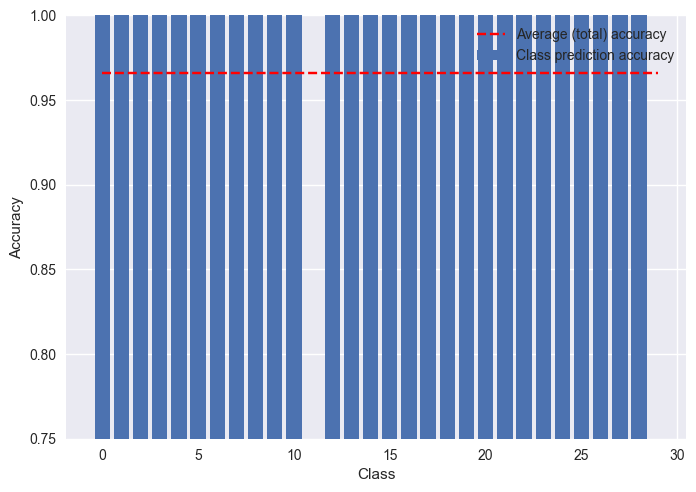

In [79]:
plt.style.use("seaborn");
plt.ylim([0.75, 1])
plt.bar(range(num_classes), class_accuracy, label="Class prediction accuracy")
plt.hlines(accuracy, 0, num_classes, colors="red", linestyles="--", label="Average (total) accuracy")
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.legend()

330
330


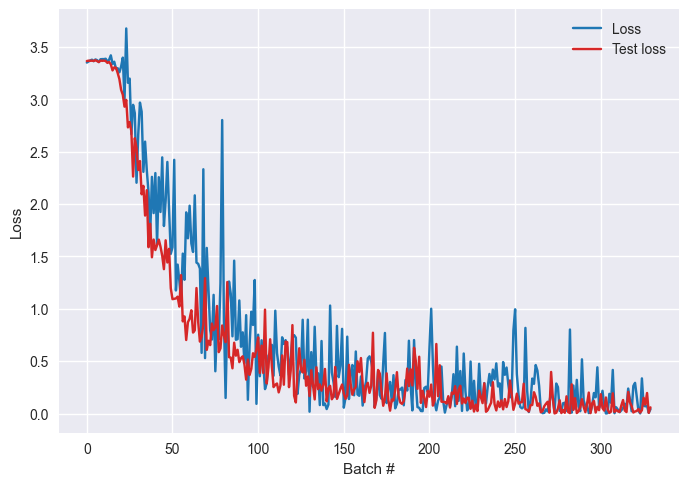

In [84]:
print(len(loss_timeline))
print(len(test_loss_timeline))
lt = list(enumerate(loss_timeline))
tlt = list(enumerate(test_loss_timeline))
fig = plt.figure()
ax = fig.add_subplot()
ax.plot([x[0] for x in lt], [x[1] for x in lt], label='Loss', color='tab:blue')
ax.plot([x[0] for x in tlt], [x[1] for x in tlt], label='Test loss', color='tab:red')
ax.legend()
plt.xlabel('Batch #')
plt.ylabel('Loss')
plt.show()